<a href="https://colab.research.google.com/github/JustAlex5/deep_learning/blob/main/Final_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





**Alex Kovalyov** 



import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,Input
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout
import numpy as np
from tensorflow.keras.layers import SimpleRNN, LSTM ,RepeatVector,Reshape
from tensorflow.keras.utils import to_categorical
import re
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
from PIL import Image
import datetime
from tensorflow.keras.utils import plot_model
from seaborn import heatmap

%load_ext tensorboard

from keras.applications.vgg16 import VGG16
print(tf.__version__)


2.8.0


load MNIST Dataset

MNIST_train_images.shape = (60000, 28, 28, 1)
MNIST_train_labels.shape = (60000,)
MNIST_test_images.shape = (10000, 28, 28, 1)
MNIST_test_labels.shape = (10000,)


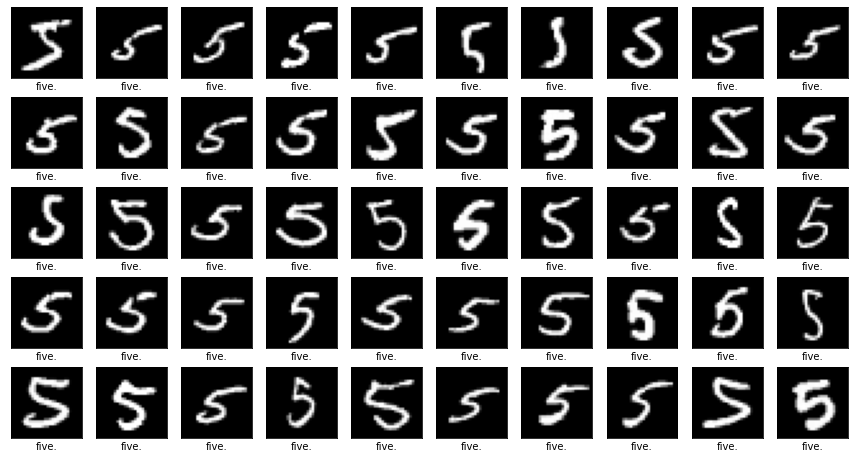

In [ ]:
(MNIST_train_images, MNIST_train_labels), (MNIST_test_images, MNIST_test_labels) = tf.keras.datasets.mnist.load_data()

# 2. flatten the labels (easier to deal with)
MNIST_train_labels = MNIST_train_labels.flatten()  # (50000, 1) -> (50000,)
MNIST_test_labels = MNIST_test_labels.flatten()    # (10000, 1) -> (10000,)

# 3. convert uint8->float32 and normalize range to 0.0-1.0 
MNIST_train_images = MNIST_train_images.astype('float32') / 255.0
MNIST_test_images = MNIST_test_images.astype('float32') / 255.0

# 4. expand the dimensions (tensorflow expects images in a (H,W,C) format):
# (Height, Width, Channel), in our case we have 3 color channels (R,G,B)
MNIST_train_images = MNIST_train_images[...,None]
MNIST_test_images = MNIST_test_images[..., None]

# 5. print the shapes
print('MNIST_train_images.shape =',MNIST_train_images.shape)
print('MNIST_train_labels.shape =',MNIST_train_labels.shape)
print('MNIST_test_images.shape =',MNIST_test_images.shape)
print('MNIST_test_labels.shape =',MNIST_test_labels.shape)


class_names = ['zero.','one.', 'two.', 'three.', 'four.', 'five.',
               'six.', 'seven.', 'eight.', 'nine.']

# 6. lets plot some "5"s (just for fun)
[idx] = np.where(MNIST_train_labels==5) # find all the "5"s
plt.figure(figsize=(15,8))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(MNIST_train_images[idx[i],:,:,0], cmap='gray')
    plt.xlabel(class_names[MNIST_train_labels[idx[i]]])
    plt.xticks([]), plt.yticks([])

Build CNN Model 

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (1, 1), activation='relu', input_shape=(28,28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(MNIST_train_images, MNIST_train_labels, epochs=10, 
                    validation_data=(MNIST_test_images, MNIST_test_labels))





Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.0617 - accuracy: 0.6407 - val_loss: 0.8823 - val_accuracy: 0.7068
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7918 - accuracy: 0.7336 - val_loss: 0.7101 - val_accuracy: 0.7675
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6993 - accuracy: 0.7653 - val_loss: 0.6628 - val_accuracy: 0.7830
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6511 - accuracy: 0.7808 - val_loss: 0.6274 - val_accuracy: 0.7951
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6211 - accuracy: 0.7929 - val_loss: 0.5965 - val_accuracy: 0.8041
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5958 - accuracy: 0.8008 - val_loss: 0.5860 - val_accuracy: 0.8097
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5753 - accuracy: 0.8085 - val_loss: 0.5684 - val_accuracy:

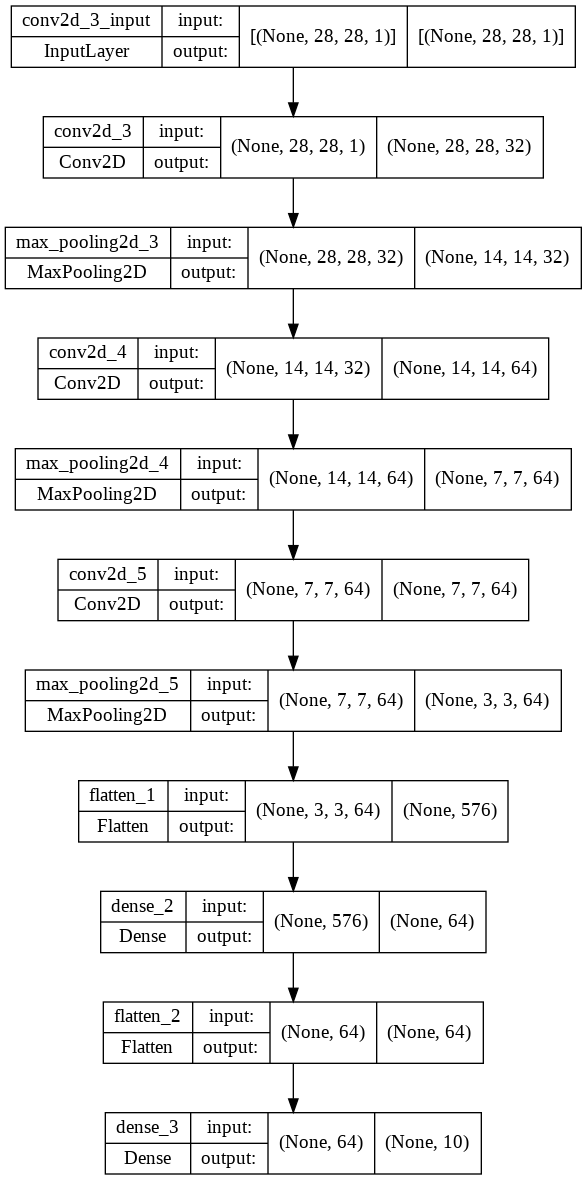

In [ ]:
plot_model(model, show_shapes=True)

313/313 - 1s - loss: 0.5580 - accuracy: 0.8181 - 556ms/epoch - 2ms/step


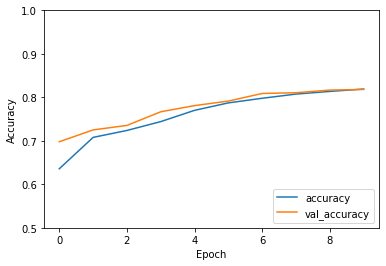

In [ ]:


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(MNIST_test_images,  MNIST_test_labels, verbose=2)



# Preproccesing for RNN model

In [ ]:
y_test=[]
y_train=[]

In [ ]:
#Convert the Y lable into words -> 8 become eight. 6 becomes six. 
for i in range(len(MNIST_test_labels)):
  y_test.append(class_names[MNIST_test_labels[i]])

for i in range(len(MNIST_train_labels)):
  y_train.append(class_names[MNIST_train_labels[i]])
                      

In [ ]:
#Convert the word to token array each row incluses the char index 
chars=' .*abcdefghijklmnopqrstuvwxyz'
char_to_ix= {ch:i for i,ch in enumerate(chars)}
ix_to_char={i:ch for i,ch in enumerate(chars)}

X = np.zeros((len(MNIST_train_images), 10, len(chars)), dtype='bool')
Y = np.zeros((len(MNIST_train_images),10,len(chars)), dtype='bool')


for i, seq in enumerate(y_train):
    for t, char in enumerate(seq):
        if t==0:
            X[i, 0, char_to_ix['*']] = 1
            X[i, t+1, char_to_ix[char]] = 1
            Y[i,0, char_to_ix[char]] = 1
        Y[i,t, char_to_ix[char]]=1
        if char=='.':
            break
        X[i, t+1, char_to_ix[char]] = 1
    X[i,t+1:,char_to_ix[' ']]=1
    Y[i,t+1:,char_to_ix[' ']]=1


In [ ]:
#example for Y in location 1000
[ix_to_char[i] for i in np.argmax(Y[1000]+0, axis=1)]

['z', 'e', 'r', 'o', '.', ' ', ' ', ' ', ' ', ' ']

In [ ]:
#example for X in same position 
[ix_to_char[i] for i in np.argmax(X[1000]+0, axis=1)]

['*', 'z', 'e', 'r', 'o', ' ', ' ', ' ', ' ', ' ']

Ful modelL there two inputs the feture vectr from CNN len 64 - the layer in postion -1 and the decoded matrix 10*29. the output is the trained matrix 

In [ ]:
encoder_inputs = Input(shape=(28, 28, 1))
encoder = Sequential()
#prepare the CNN model while the output is the layer -1 . thos layer containes the 
# deture vector in size 64. 

for layer in model.layers[:-1]: 
    encoder.add(layer)
#adding Dense layer for the input to the RNN model
encoder.add(Dense(16, activation='softmax'))

#using the trained weight from the first section of CNN. 
for layer in encoder.layers[:-1]:
    layer.trainable = False

#config the input of the encoder 

encoder_states = encoder(encoder_inputs)

#config input for the decoder the matrix of one hot endoding 
decoder_inputs = Input(shape=(None, len(chars)))


decoder_rnn = SimpleRNN(16, return_sequences=True)
decoder_outputs= decoder_rnn(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(len(chars), activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

#ombine the full model: the are two inputs and one output 
# input the MNIST IMAGE and Matrix of chars and the output is the predicted char each row.
full_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

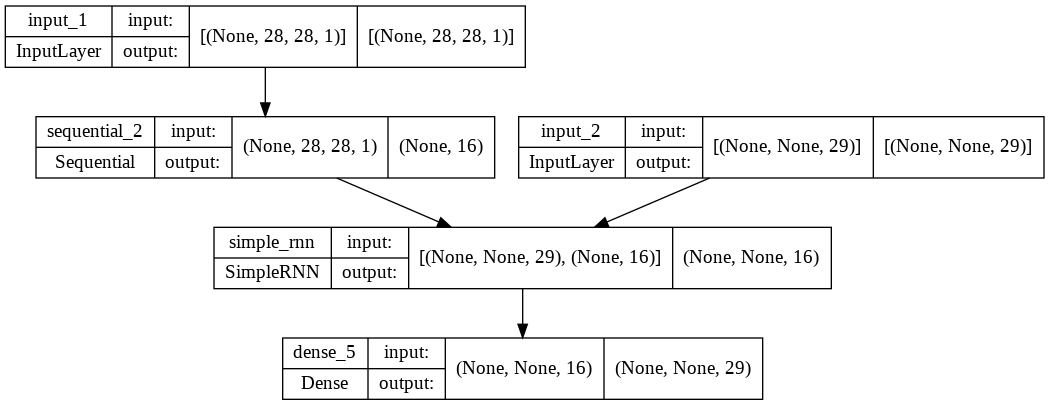

In [ ]:
plot_model(full_model, show_shapes=True)

In [ ]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 29)]   0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 16)           44304       ['input_1[0][0]']                
                                                                                                  
 simple_rnn (SimpleRNN)         (None, None, 16)     736         ['input_2[0][0]',                
                                                                  'sequential_1[0][0]']       

In [ ]:
chars=' .*abcdefghijklmnopqrstuvwxyz'
class_names = ['zero','one', 'two', 'three', 'four', 'five','six', 'seven', 'eight', 'nine']
char_to_ix= {ch:i for i,ch in enumerate(chars)}
ix_to_char={i:ch for i,ch in enumerate(chars)}

X_test = np.zeros((len(MNIST_test_images), 10, len(chars)), dtype='bool')
Y_test = np.zeros((len(MNIST_test_images),10,len(chars)), dtype='bool')


for i, seq in enumerate(y_test):
    for t, char in enumerate(seq):
        if t==0:
            X_test[i, 0, char_to_ix['*']] = 1
            X_test[i, t+1, char_to_ix[char]] = 1
            Y_test[i,0, char_to_ix[char]] = 1
        Y_test[i,t, char_to_ix[char]]=1
        if char=='.':
            break
        X_test[i, t+1, char_to_ix[char]] = 1
    X_test[i,t+1:,char_to_ix[' ']]=1
    Y_test[i,t+1:,char_to_ix[' ']]=1

In [ ]:
full_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history=full_model.fit([MNIST_train_images, X],Y,batch_size=64,epochs=5,verbose=1,validation_data=([MNIST_test_images,X_test],Y_test))

Epoch 1/5
938/938 [==============================] - 10s 9ms/step - loss: 0.0756 - accuracy: 0.9734 - val_loss: 0.0741 - val_accuracy: 0.9740
Epoch 2/5
938/938 [==============================] - 8s 9ms/step - loss: 0.0730 - accuracy: 0.9743 - val_loss: 0.0723 - val_accuracy: 0.9745
Epoch 3/5
938/938 [==============================] - 9s 9ms/step - loss: 0.0716 - accuracy: 0.9746 - val_loss: 0.0716 - val_accuracy: 0.9750
Epoch 4/5
938/938 [==============================] - 9s 9ms/step - loss: 0.0708 - accuracy: 0.9750 - val_loss: 0.0713 - val_accuracy: 0.9752
Epoch 5/5
938/938 [==============================] - 9s 9ms/step - loss: 0.0702 - accuracy: 0.9752 - val_loss: 0.0707 - val_accuracy: 0.9750


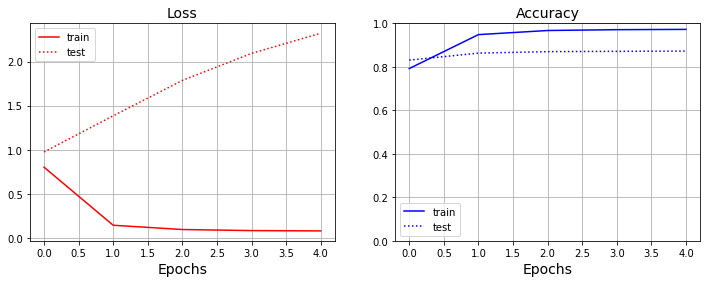

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],'r', label='train')
plt.plot(history.history['val_loss'],':r', label='test')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],'b', label='train')
plt.plot(history.history['val_accuracy'],':b', label='test')
plt.ylim([0, 1])
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend()
plt.grid()

## **Prediction**

In [ ]:
i=np.random.randint(10000)

Text(0.5, 1.0, 'The real result for first char in index:9142')

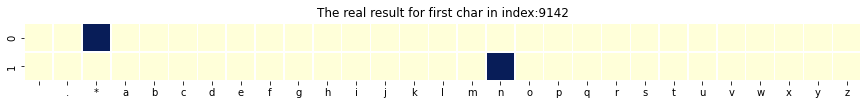

In [ ]:

plt.figure(figsize=(15,7))

heatmap(np.array(X_test[i][:2]),square=True,xticklabels=chars, 
        cmap='YlGnBu',linewidths=0.5, cbar=False)
plt.title(f'The real result for first char in index:{i}')

In [ ]:
MNIST_test_labels[i]

9

In [ ]:
#define new matrix for predict: For this case only the first row contain the spacial key '*' and other rows are empty.

X_test_new = X_test[:len(MNIST_test_labels),0:1,:]

In [ ]:
#Predict the first char of word
preicted_test=full_model.predict([MNIST_test_images,X_test_new])

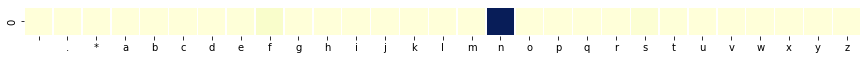

In [ ]:
#Some vizualize for the first char from predict
plt.figure(figsize=(15,7))
heatmap(np.array(preicted_test[i]),square=True,xticklabels=chars, 
        cmap='YlGnBu',linewidths=0.5, cbar=False)

# predict  full model

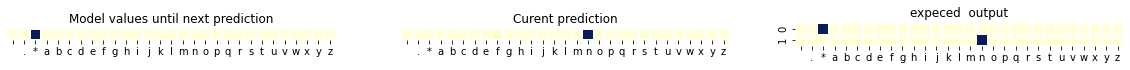

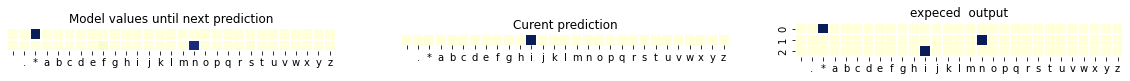

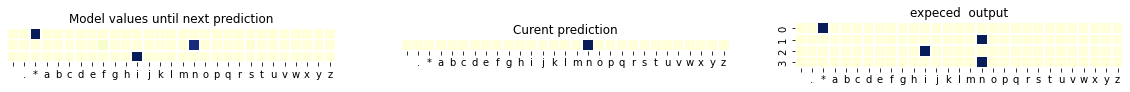

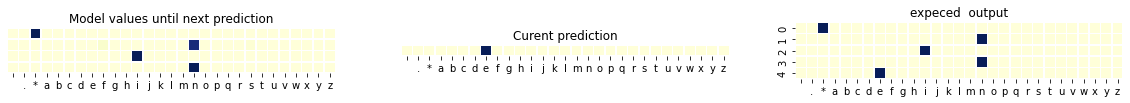

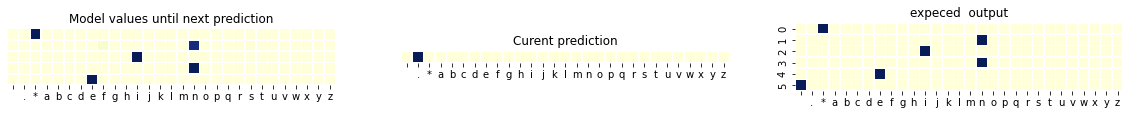

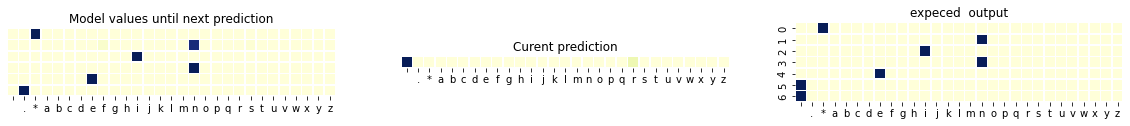

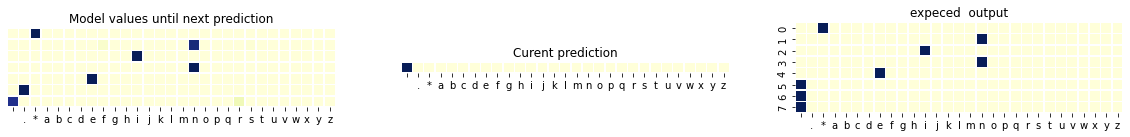

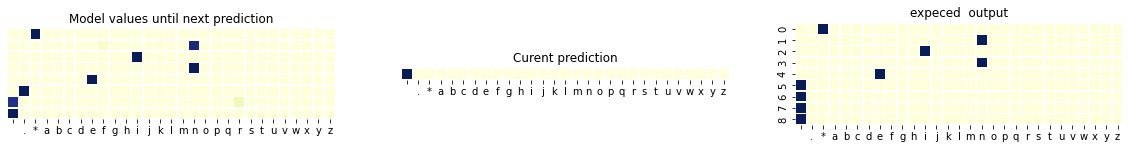

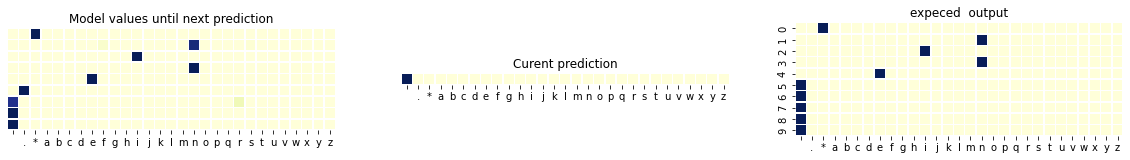

In [ ]:
#Lets build the full prediction for random image from MNIST test set 



X_test_final = X_test[:len(MNIST_test_labels),0:1,:]

#predict the 
predict_next_char = full_model.predict([MNIST_test_images,X_test_final])

#lets predict the next chars from the second one to the last. 
for j in range(1,10):
  #Add the new char the the matrix , this char will be the trigger for prediction of the next char 

  next_char = np.concatenate([X_test_final, predict_next_char], axis=1)

  plt.figure(figsize=(20,10))

  plt.subplot(1,3,1)
  heatmap(np.array(next_char[i][:-1][:]),square=True,xticklabels=chars,yticklabels=False,
        cmap='YlGnBu',linewidths=0.5, cbar=False)
  stri = 'Model values until next prediction'
  plt.title(stri)

  plt.subplot(1,3,2)
  heatmap(np.array(next_char[i][-1][:]).reshape(29,1).T,square=True,xticklabels=chars,yticklabels=False,
        cmap='YlGnBu',linewidths=0.5, cbar=False)
  stri = 'Curent prediction'
  plt.title(stri)

  plt.subplot(1,3,3)
  heatmap(np.array(X_test[i,:j+1 ,:]),square=True,xticklabels=chars,
        cmap='YlGnBu',linewidths=0.5, cbar=False)
  plt.title('expeced  output')
  plt.show()
#predict the next char 
  predict_next_char = full_model.predict([MNIST_test_images,next_char])

In [ ]:
[ix_to_char[i] for i in np.argmax(Y_test[1413]+0, axis=1)]

['f', 'o', 'u', 'r', ' ', ' ', ' ', ' ', ' ', ' ']

In [ ]:
[ix_to_char[i] for i in np.argmax(X_test[1413]+0, axis=1)]

['*', 'f', 'o', 'u', 'r', ' ', ' ', ' ', ' ', ' ']

In [ ]:
[ix_to_char[i] for i in np.argmax(next_char[1413]+0, axis=1)]

['*', 'f', 'i', 'u', 'r', '.', 'n', '.', 'n', 'i']

In [ ]:
np.argmax(X_test[9142]+0, axis=1)

array([ 2, 16, 11, 16,  7,  0,  0,  0,  0,  0])

In [ ]:
xxx=np.argmax(next_char[9142]+0, axis=1)

In [ ]:
xxx = np.where(xxx == 1, 0, xxx)

In [ ]:
count=0
res=[]
for i in range(len(MNIST_test_labels)):
  original_test=np.argmax(X_test[i]+0, axis=1)
  predicted_res=xxx=np.argmax(next_char[i]+0, axis=1)
  predicted_res=np.where(predicted_res == 1, 0, predicted_res)
  if np.array_equal(original_test,predicted_res):
    continue
  else:
    res.append(i)
    count+=1



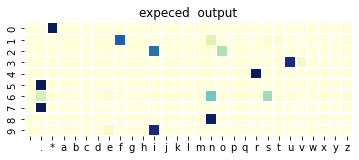

In [ ]:
  plt.figure(figsize=(20,10))

  plt.subplot(1,3,3)
  heatmap(np.array(next_char[1413,: ,:]),square=True,xticklabels=chars,
        cmap='YlGnBu',linewidths=0.5, cbar=False)
  plt.title('expeced  output')
  plt.show()